In [21]:
from bs4 import BeautifulSoup # scraper
import urllib # a library for open webpages and downloading content
impor time # will use to sleep 1 sec between requests (to avoid being blocked)

Our goal is to obtain profile pictures from https://www.govtrack.us/congress/members

Although we can provide a least of states ourselves, let's find the available list of states as a warmup exercise

In [2]:
url = 'https://www.govtrack.us/congress/members'
req = urllib.request.urlopen(url)

In [3]:
bs = BeautifulSoup(req, 'html.parser')

In [4]:
bs.find(id="state")

<select class="form-control" id="state" onchange="if (this.value != '') window.location='/congress/members/' + this.value">
<option value="">(Select State)</option>
<option value="AL">AL - Alabama</option>
<option value="AK">AK - Alaska</option>
<option value="AS">AS - American Samoa</option>
<option value="AZ">AZ - Arizona</option>
<option value="AR">AR - Arkansas</option>
<option value="CA">CA - California</option>
<option value="CO">CO - Colorado</option>
<option value="CT">CT - Connecticut</option>
<option value="DE">DE - Delaware</option>
<option value="DC">DC - District of Columbia</option>
<option value="FL">FL - Florida</option>
<option value="GA">GA - Georgia</option>
<option value="GU">GU - Guam</option>
<option value="HI">HI - Hawaii</option>
<option value="ID">ID - Idaho</option>
<option value="IL">IL - Illinois</option>
<option value="IN">IN - Indiana</option>
<option value="IA">IA - Iowa</option>
<option value="KS">KS - Kansas</option>
<option value="KY">KY - Kentucky</op

We want to extract the attribute `value` from the tags `option`

In [5]:
options = bs.find(id='state').find_all('option')
state_codes = [x['value'] for x in options if x['value'] != '']

In [6]:
state_codes

['AL',
 'AK',
 'AS',
 'AZ',
 'AR',
 'CA',
 'CO',
 'CT',
 'DE',
 'DC',
 'FL',
 'GA',
 'GU',
 'HI',
 'ID',
 'IL',
 'IN',
 'IA',
 'KS',
 'KY',
 'LA',
 'ME',
 'MD',
 'MA',
 'MI',
 'MN',
 'MS',
 'MO',
 'MT',
 'NE',
 'NV',
 'NH',
 'NJ',
 'NM',
 'NY',
 'NC',
 'ND',
 'MP',
 'OH',
 'OK',
 'OR',
 'PA',
 'PR',
 'RI',
 'SC',
 'SD',
 'TN',
 'TX',
 'UT',
 'VT',
 'VI',
 'VA',
 'WA',
 'WV',
 'WI',
 'WY']

Great! Now we want to visit the website of each state and gather the photo. We need a function that easily creates the url's for each state

In [7]:
def state_url(state_code):
    """    
    args
        state_code: a string of length 2 with the state code, e.g. 'TX'
    returns
        the url of the state
    """
    return 'https://www.govtrack.us/congress/members/' + state_code

In [8]:
state_url('TX')

'https://www.govtrack.us/congress/members/TX'

Now there's a catch, not all states/territories have senators, e.g., American Samoa is in the above list, and it doesn't have senators.

In [9]:
def has_senators(x):
    """    
    params
    x: a bs object
    returns
    true if x is a state with senators (a real state, not territory)
    """
    search_senator_header = x.find('h2', text='Senators') # returns None if it finds nothing
    if search_senator_header is None:
        return False
    else:
        return True

Note that there are multiple solutions to the above. You could have also noted that with senators there is a `div` with id `senators`. This is perhaps an easier way. I will leave it to you as homeworks to implement this approach. Below are the results

In [10]:
url_tx = state_url('TX') # Can't remember what state is this one
req_tx = urllib.request.urlopen(url_tx)
bs_tx = BeautifulSoup(req_tx, 'html.parser')

has_senators(bs_tx) # does texas have senators

True

In [11]:
url_as = state_url('AS') # American Samoa
req_as = urllib.request.urlopen(url_as) 
bs_as = BeautifulSoup(req_as, 'html.parser')

has_senators(bs_as) # does american samoa have senators

False

Now let's do something a bit harder. Let's get the senator names. After some inspection, we see that the piece of code in which they are listed.

In [12]:
bs_tx.find(id='senators').find_all('p', class_='moc')

[<p class="moc"><a class="plain" href="/congress/members/john_cornyn/300027">John Cornyn</a></p>,
 <p class="moc"><a class="plain" href="/congress/members/ted_cruz/412573">Ted Cruz</a></p>]

Now this is the part that requires some clever insepction. We recognize that there is a `href` that links to the specific senator website. Moreover, we see a unique id assigned to him. When we inspect the senators photo, we realize that this id is used to create a url for his photo. Namely,

In [13]:
bs_tx.find(id='senators').find_all('div', class_='photo')

[<div class="photo">
 <a href="/congress/members/john_cornyn/300027"><img alt="John Cornyn" height="120" src="/data/photos/300027-100px.jpeg" width="100"/></a>
 </div>, <div class="photo">
 <a href="/congress/members/ted_cruz/412573"><img alt="Ted Cruz" height="120" src="/data/photos/412573-100px.jpeg" width="100"/></a>
 </div>]

The photos that appear here are thumbails, that's why they have `-100px` in the name. It turns out that we can remove this indicator and get a full size image. Or change it by `200-px` and get a medium size. I just know this because I just spent some minutes looking at their website.

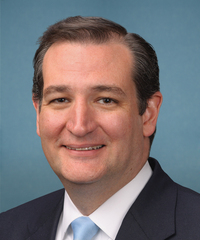

In [37]:
from PIL import Image # just used for this example (so an image shows in the notebook)
from io import BytesIO # just used for this example (so an image shows in the notebook)
import requests # alternative to urlopen / just used for this example (so an image shows in the notebook)

example_image_url = 'https://www.govtrack.us//data/photos/412573-200px.jpeg'

Image.open(BytesIO(requests.get(example_image_url).content))

Now we are ready! All photos will be stored in the folder `SenatorPhotos`.

In [53]:
def download_photos(state_codes):
    for code in state_codes:
        # download state website and parse it with Beutiful Soup
        req_state = urllib.request.urlopen(state_url(code))
        bs_state = BeautifulSoup(req_state, 'html.parser')      
        
        # download photos if has photos
        if has_senators(bs_state):
            print("Downloading images from senators of", code + "...")
            
            photo_divs = bs_state.find(id='senators').find_all('div', class_='photo')
            
            for div in photo_divs:
                senator_name = div.img['alt']
                image_url = 'https://www.govtrack.us' + div.img['src'][:-11] + '.jpeg'
                
                try: 
                    requested_image = urllib.request.urlopen(image_url)
                    filename = 'SenatorPhotos/' + senator_name + '.jpeg'
                
                    # try to download image or print error
                    with open(filename, 'wb') as f:
                        f.write(requested_image.read())   
                    
                    print(senator_name + "...", "Done.")
                except: 
                    print(senator_name + "...", "ERROR!")
                    
                time.sleep(1) # politeness

In [ ]:
download_photos(state_codes[10:])

Marco Rubio... Done.
Rick Scott... ERROR!
John “Johnny” Isakson... Done.
David Perdue... Done.
Brian Schatz... Done.
Mazie Hirono... Done.
Michael Crapo... Done.
James Risch... Done.
Richard Durbin... Done.
Tammy Duckworth... Done.
Todd Young... Done.
Mike Braun... ERROR!
Charles “Chuck” Grassley... Done.
Joni Ernst... Done.
Pat Roberts... Done.
Jerry Moran... Done.
Mitch McConnell... Done.
Rand Paul... Done.
Bill Cassidy... Done.
John Kennedy... Done.
Susan Collins... Done.
Angus King... Done.
Benjamin Cardin... Done.
Chris Van Hollen Jr.... Done.
Elizabeth Warren... Done.
Edward “Ed” Markey... Done.
Debbie Stabenow... Done.
Gary Peters... Done.
Amy Klobuchar... Done.
Tina Smith... Done.
Roger Wicker... Done.
Cindy Hyde-Smith... ERROR!
Roy Blunt... Done.
Joshua Hawley... ERROR!
Jon Tester... Done.
Steve Daines... Done.
